🧠 Hyperparameter Tuning for MLP
Date: May 21, 2025

🎯 Goal
Identify the optimal configuration of hyperparameters for a Multi-Layer Perceptron (MLP) model, including:

hidden_dim: number of hidden units

learning_rate: optimizer step size

batch_size: number of samples per training step

activation_fn: activation function

optimizer: optimization algorithm

⚙️ General Settings
epochs = 100

output_dim = 1

n_runs = 30 (random seeds for reproducibility)

📌 Tuned Parameters
Hidden Dimensions: [64, 128]

Learning Rate: [0.007, 0.008, 0.009, 0.01]

Batch Size: [16, 32, 64]

Activation Functions: [nn.Tanh]
(can be extended to [nn.ReLU, nn.LeakyReLU, nn.Tanh])

Optimizers: ["Adam"]
(optionally expandable to ["Adam", "AdamW", "SGD", "RMSprop"])

📊 Training Procedure
Each configuration is trained using 5-fold cross-validation

Early stopping is applied with patience = 100

Metrics are calculated on each fold and averaged:

R² (coefficient of determination)

MAE (mean absolute error)

MSE (mean squared error)

💾 Outputs Saved
Model weights

Configuration files

Evaluation metrics per run

Global experiment log (experiments_log.csv)

Training visualizations (loss_plot.png)

🏁 Final Results
Table of stable configurations (R² ≥ 95% of the best score)

Visual analysis of hyperparameter impact (boxplots per parameter)

Best configuration is highlighted separately

In [82]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm




In [83]:
# ➤ Paths for hyperparameter search: tuning runs, logs, results

# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_train.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

os.makedirs(TUNING_DIR, exist_ok=True)

# ➤ Function to create a run-specific directory
def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, activation_fn=None, optimizer_name=None, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"

    # 👇 Добавим активацию в имя, если она передана
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"

    # 👇 Добавим имя оптимизатора в имя, если оно передано
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

🛠 Device: cpu


In [84]:
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [85]:
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [86]:
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [87]:
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam"):

    # ----------------------------
    # Ensure CSV file exists and has header
    # ----------------------------
    if not os.path.exists(LOG_CSV_PATH):
        with open(LOG_CSV_PATH, "w") as f:
            f.write("run_id,hidden_dim,lr,batch_size,activation_fn,optimizer_name,R2,MAE,MSE\n")


    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔍 Проверка первых строк X и y
    print("📄 Features (X):")
    display(X.head())

    print("\n🎯 Target (y):")
    display(y.head())

    # 📐 Размерности
    print(f"\n✅ X shape: {X.shape}")
    print(f"✅ y shape: {y.shape}")


    # ----------------------------
    # K-Fold Cross-Validation
    # ----------------------------
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold + 1} / 5")

        # 📊 Разделение данных
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 🔁 Преобразуем в тензоры
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

        # 📦 DataLoader с правильным порядком
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        print("X_train.shape =", X_train.shape)


        # 🧠 Создание новой модели на каждый фолд
        model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)

         # ----------------------------
        # Training loop
        # ----------------------------
        criterion = nn.MSELoss()
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        train_loss_history = []

        # 🔁 Early Stopping init
        early_stopping_patience = 20
        best_loss = float("inf")
        patience_counter = 0

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            epoch_loss = 0.0

            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            current_loss = epoch_loss / len(train_loader)
            train_loss_history.append(current_loss)

            # 💡 Early Stopping check (выполняется на каждой эпохе)
            if current_loss < best_loss:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1} — no improvement in {early_stopping_patience} epochs.")
                    break

            # ⏺️ Logging (только раз в 10 эпох)
            if (epoch + 1) % 10 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}"
                print(log_str)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor)
            metrics = evaluate_regression(y_val_tensor, y_pred)
            fold_metrics.append(metrics)
            print(f"📈 Fold {fold + 1} metrics: {metrics}")

    # ----------------------------
    # Average metrics across folds
    # ----------------------------
    avg_metrics = {
        "MSE": sum(m["MSE"] for m in fold_metrics) / len(fold_metrics),
        "MAE": sum(m["MAE"] for m in fold_metrics) / len(fold_metrics),
        "R2":  sum(m["R2"]  for m in fold_metrics) / len(fold_metrics),
    }
    
    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "activation_fn": activation_fn.__name__,
        "optimizer_name": optimizer_name,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['StdDev']
    }
    config_filename = f"config_{run_id}_ex.json"
    with open(os.path.join(run_dir, config_filename), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{batch_size},{activation_fn.__name__},{optimizer_name},{avg_metrics['R2']:.4f},{avg_metrics['MAE']:.4f},{avg_metrics['MSE']:.6f}\n")

    print(f"\n📊 Average metrics across 5 folds:\n{avg_metrics}")
    return run_id, avg_metrics
    



In [88]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
hidden_dim_choices = [128]
# hidden_dim_choices = [32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 384]

lr_choices = [0.009]
# lr_choices = [round(lr, 5) for lr in np.arange(0.001, 0.021, 0.001)]

batch_size_choices = [64]
# batch_size_choices = [8, 16, 32, 48, 64, 96, 128]
activation_choices = [nn.Tanh]
# activation_choices = [nn.ReLU, nn.LeakyReLU, nn.Tanh]
optimizer_choices = ["Adam"]
# optimizer_choices = ["Adam", "AdamW"]


#hidden_dim_choices = [128, 264]
#lr_choices = [ 1e-3, 5e-3]

# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 1 # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)
    batch_size = random.choice(batch_size_choices)
    activation_fn=random.choice(activation_choices)
    optimizer_name = random.choice(optimizer_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}, batch size: {batch_size}, activation_fn: {activation_fn.__name__}, optimizer_name: {optimizer_name}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )


🔁 Run 1/1
→ hidden_dim: 128, lr: 0.00900, batch size: 64, activation_fn: Tanh, optimizer_name: Adam


Dataset loaded: 121113 rows, 15 columns
📄 Features (X):


,X_int,Y_int,X_fac,Y_fac,Ang
0,8,6,4,5,20
1,5,3,3,4,10
2,1,5,17,8,150
3,4,6,19,8,10
4,7,3,21,1,60



🎯 Target (y):


,StdDev
0,0.166314
1,0.167147
2,0.171097
3,0.166579
4,0.267192



✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)


Epochs:  10%|█         | 10/100 [00:30<02:43,  1.82s/it]

Epoch [10/100], Loss: 0.0072


Epochs:  20%|██        | 20/100 [00:50<02:27,  1.84s/it]

Epoch [20/100], Loss: 0.0074


Epochs:  23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]


⏹️ Early stopping at epoch 24 — no improvement in 20 epochs.
📈 Fold 1 metrics: {'MSE': 0.006555794272571802, 'MAE': 0.06870196014642715, 'R2': 0.060262858867645264}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)


Epochs:  10%|█         | 10/100 [00:14<02:11,  1.46s/it]

Epoch [10/100], Loss: 0.0075


Epochs:  20%|██        | 20/100 [00:34<02:17,  1.72s/it]

Epoch [20/100], Loss: 0.0073


Epochs:  23%|██▎       | 23/100 [00:42<02:23,  1.86s/it]


⏹️ Early stopping at epoch 24 — no improvement in 20 epochs.
📈 Fold 2 metrics: {'MSE': 0.020205138251185417, 'MAE': 0.12891320884227753, 'R2': -1.905674934387207}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)


Epochs:  10%|█         | 10/100 [00:18<02:40,  1.78s/it]

Epoch [10/100], Loss: 0.0078


Epochs:  20%|██        | 20/100 [00:36<02:32,  1.91s/it]

Epoch [20/100], Loss: 0.0080


Epochs:  22%|██▏       | 22/100 [00:42<02:30,  1.93s/it]


⏹️ Early stopping at epoch 23 — no improvement in 20 epochs.
📈 Fold 3 metrics: {'MSE': 0.0063703046180307865, 'MAE': 0.06751635670661926, 'R2': 0.09175169467926025}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)


Epochs:  10%|█         | 10/100 [00:19<02:37,  1.75s/it]

Epoch [10/100], Loss: 0.0075


Epochs:  20%|██        | 20/100 [00:38<03:19,  2.49s/it]

Epoch [20/100], Loss: 0.0062


Epochs:  22%|██▏       | 22/100 [00:43<02:34,  1.98s/it]


⏹️ Early stopping at epoch 23 — no improvement in 20 epochs.
📈 Fold 4 metrics: {'MSE': 0.007061833515763283, 'MAE': 0.06932210177183151, 'R2': -0.03778076171875}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)


Epochs:  10%|█         | 10/100 [00:14<02:09,  1.44s/it]

Epoch [10/100], Loss: 0.0073


Epochs:  20%|██        | 20/100 [00:36<02:31,  1.89s/it]

Epoch [20/100], Loss: 0.0078


Epochs:  24%|██▍       | 24/100 [00:46<02:27,  1.94s/it]

⏹️ Early stopping at epoch 25 — no improvement in 20 epochs.
📈 Fold 5 metrics: {'MSE': 0.006247005891054869, 'MAE': 0.05536286160349846, 'R2': 0.0898180603981018}
📂 Created run directory: /mnt/d/projects/wind_fluctuation_prediction_2025/experiments/tuning_mlp/mlp_128h_9e-03lr_64bs_100ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.009288015309721231, 'MAE': 0.07796329781413078, 'R2': -0.3403246164321899}


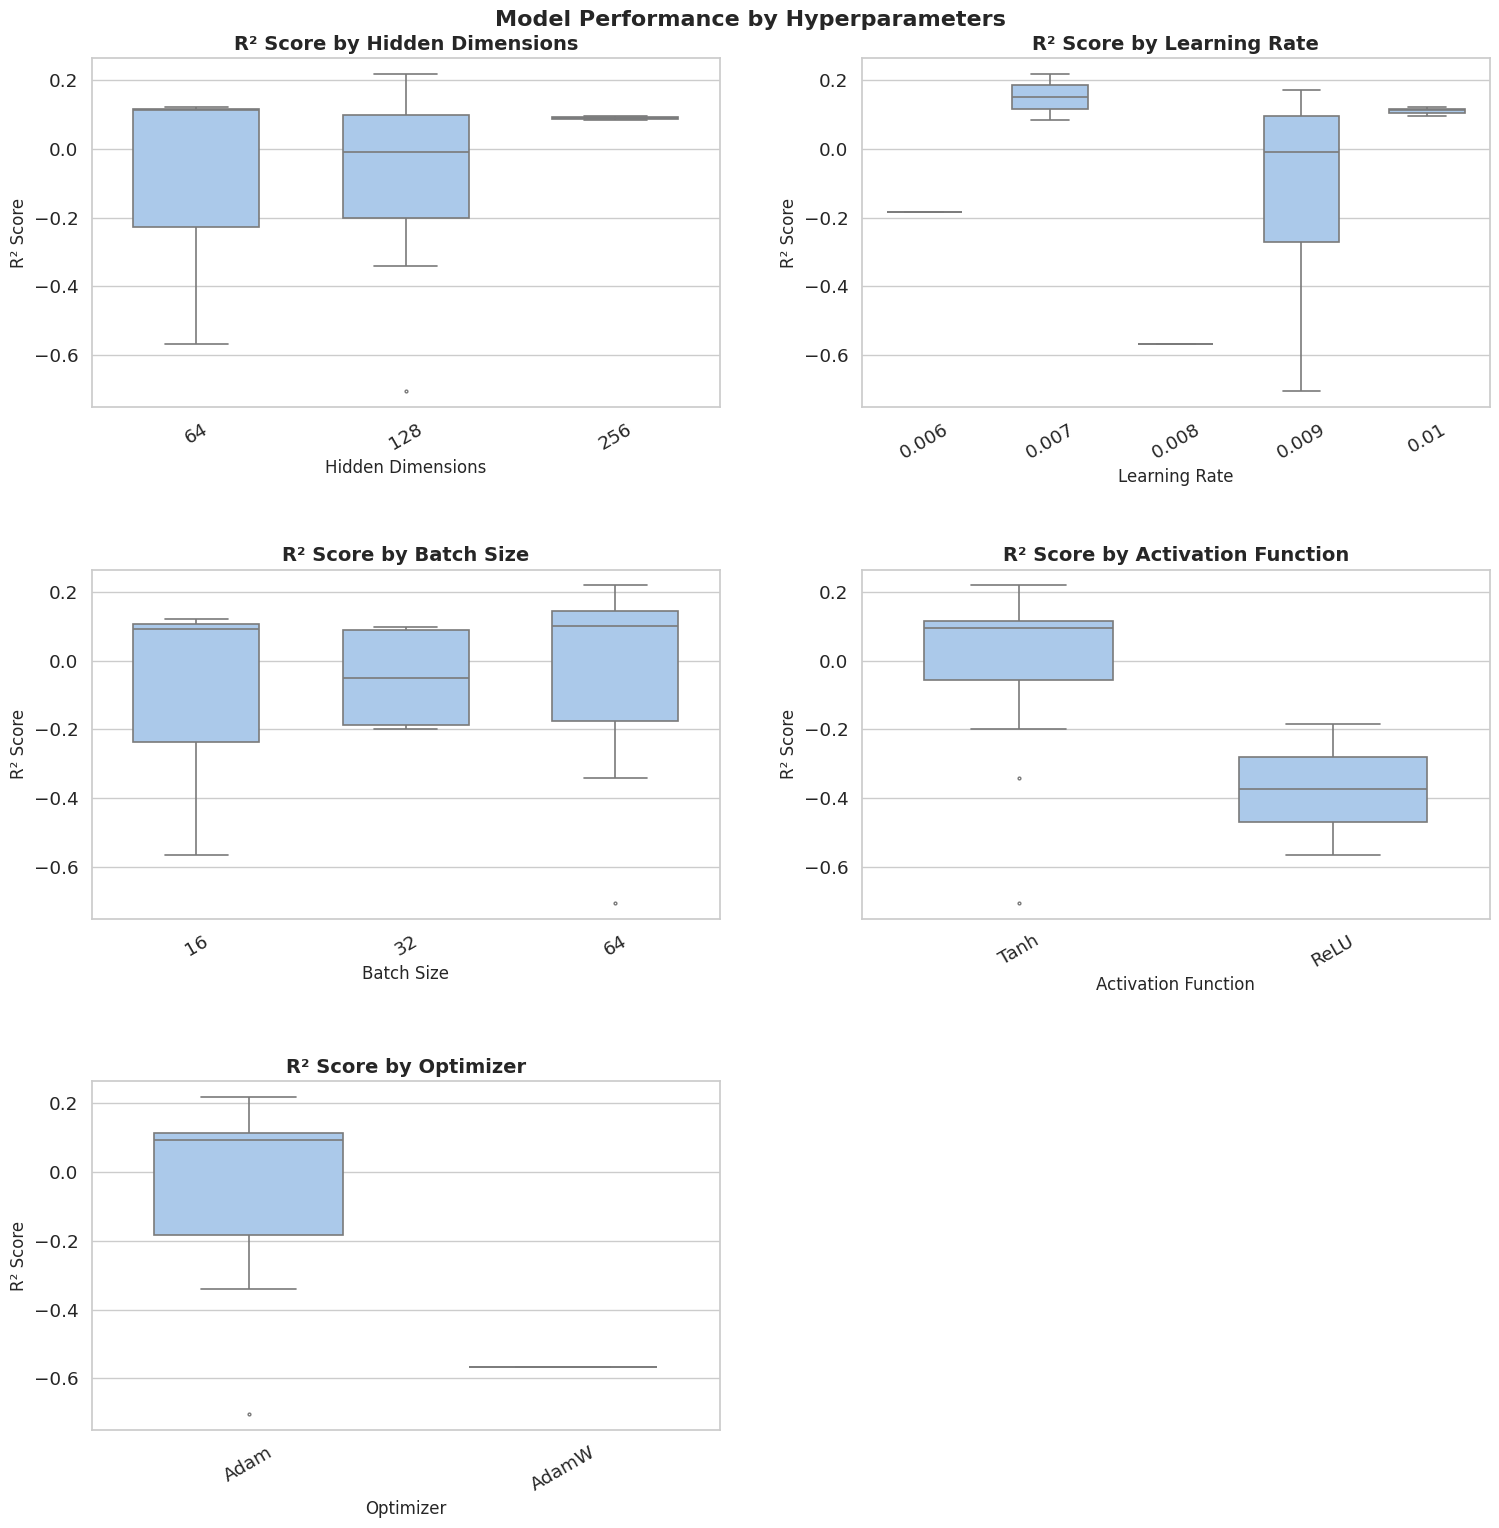


Best Configuration:
Run ID        : mlp_128h_7e-03lr_64bs_100ep_Tanh_Adam
Hidden Dim    : 128
Learning Rate : 0.00700
Batch Size    : 64
Activation Fn : Tanh
Optimizer     : Adam
R² Score      : 0.2187
MAE           : 0.0547
MSE           : 0.005411

 R² threshold (95% of max): 0.2078
🔍 Found 1 stable candidates:

   hidden_dim     lr  batch_size activation_fn optimizer_name      R2     MAE  \
7         128  0.007          64          Tanh           Adam  0.2187  0.0547   

        MSE  
7  0.005411  


In [89]:
# 📁 src/tuning/visualize_search_results.py
# ➞ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📅 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH)

# Современный стиль
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Создаём 3×2 подграфика
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Список параметров и названий
plot_params = [
    ("hidden_dim", "Hidden Dimensions"),
    ("lr", "Learning Rate"),
    ("batch_size", "Batch Size"),
    ("activation_fn", "Activation Function"),
    ("optimizer_name", "Optimizer")
]

# Строим графики
for i, (param, label) in enumerate(plot_params):
    ax = axes[i]
    sns.boxplot(x=param, y="R2", data=df_log, ax=ax, width=0.6, fliersize=2, linewidth=1.2)
    ax.set_title(f"R² Score by {label}", fontsize=14, fontweight='bold')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel("R² Score", fontsize=12)
    ax.xaxis.set_tick_params(rotation=30)

# Удаляем последний пустой subplot, если графиков меньше
if len(axes) > len(plot_params):
    fig.delaxes(axes[-1])

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.95)
fig.suptitle("Model Performance by Hyperparameters", fontsize=16, fontweight='bold')

plt.show()

# Выводим лучшую конфигурацию
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\nBest Configuration:")
print(f"Run ID        : {best_row['run_id']}")
print(f"Hidden Dim    : {int(best_row['hidden_dim'])}")
print(f"Learning Rate : {best_row['lr']:.5f}")
print(f"Batch Size    : {int(best_row['batch_size'])}")
print(f"Activation Fn : {best_row['activation_fn']}")
print(f"Optimizer     : {best_row['optimizer_name']}")
print(f"R² Score      : {best_row['R2']:.4f}")
print(f"MAE           : {best_row['MAE']:.4f}")
print(f"MSE           : {best_row['MSE']:.6f}")

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "batch_size", "activation_fn", "optimizer_name", "R2", "MAE", "MSE"]])
